In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from scipy.sparse.linalg import splu
from scipy.linalg import lu_factor
import itertools
import time
import os
import sys
import json
import pandas as pd
import h5py 

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread
#from fom import full_order_solution

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1942/3368203644.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1942/3368203644.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [2]:
import json
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]
FISSION_RATE = parameters["FISSION_RATE"]  
T_BC = parameters["T_BC"]  
LENGTH = parameters["LENGTH"]  
RADIUS = parameters["RADIUS"]  
FISSION_YIELD = parameters["FISSION_YIELD"]  
FUEL_THERMAL_CONDUCTIVITY  = parameters["FUEL_THERMAL_CONDUCTIVITY"]  
TIME_DELTA= 1.00E+04                                    #[W/(m K)]

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

## **FOM**

In [3]:
sol_new_C, average_C = full_order_solution(TIME_FINAL = 1.00E+07, TIME_DELTA = 1.00E+04)
np.savetxt('reference case/Fullorder_Cfield.csv', sol_new_C[:, :], delimiter=',', fmt='%d')         #Salvo il campo di concentrazione ad ogni istante di tempo
np.savetxt('reference case/Fullorder_Caverage.csv', average_C[:], delimiter=',', fmt='%d')          #Salvo la concentrazione media ad ogni istante di tempo
print(sol_new_C.shape)
print(average_C.shape)

NameError: name 'full_order_solution' is not defined

In [3]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
print(sol_new_C.shape)

(10201, 1001)


In [4]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

Degree of freedom = 10201


1.6350430639629565e+25


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


La quota z al valore massimo della concentrazione è: 0.982062 m


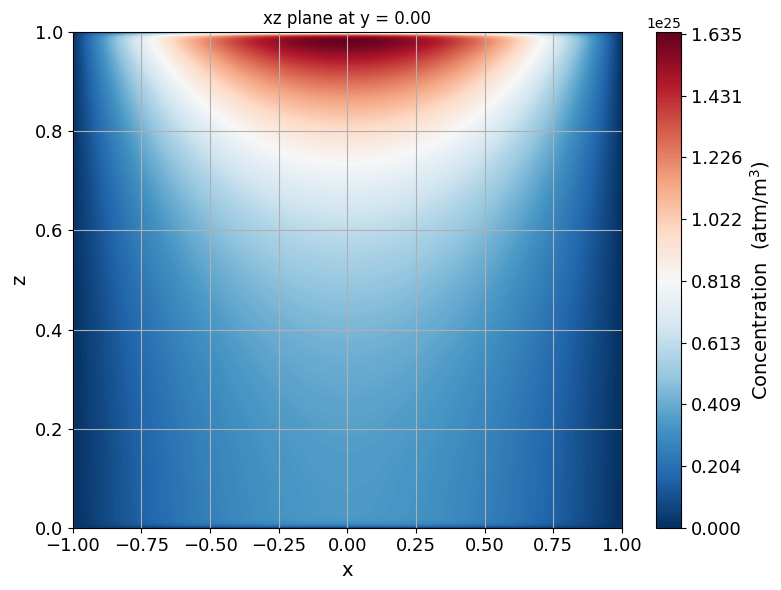

In [6]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, -1] / volume

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = 0.2e25
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 

#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x',fontsize=14)
plt.ylabel('z',fontsize=14)
plt.title('xz plane at y = 0.00')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/reference case/FOM_xz.png', bbox_inches='tight')

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(field)  # Indice del valore massimo
z_max = coord_z[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

(10201,)
1.6350430639629565e+25


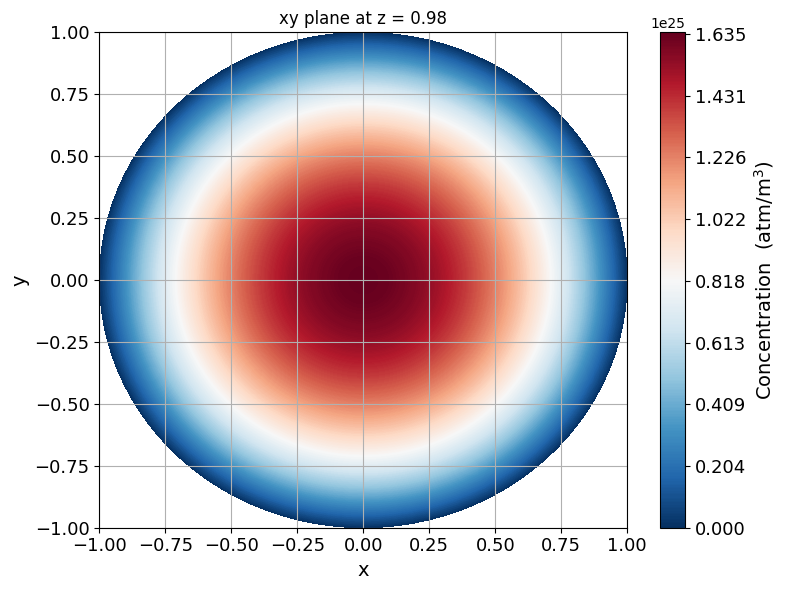

In [7]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, -1] / volume

field = sol_new_C[:, -1] / volume
coord_x = np.hstack((coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1]))
print(coord_x.shape)

z_target = z_max
z_tolerance = 0.0001  # tolleranza per z_target
mask = np.abs(coord_z - z_target) < z_tolerance
filtered_x = coord_x[mask]  # valori di x corrispondenti a z = 0.5
filtered_field = field[mask]  # campo in corrispondenza di z = 0.5

theta = np.linspace(0, 2 * np.pi, len(filtered_x))
r = coord_x  # assumendo che x sia la coordinata radiale
R, T = np.meshgrid(filtered_x, theta)  # griglia cilindrica
X = R * np.cos(T)  # trasformazione in X cartesiana
Y = R * np.sin(T)  # trasformazione in Y cartesiana
field_rotated = np.tile(filtered_field, (len(theta), 1))


max_tick = np.max(field)
tick_step = 0.2e25
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, field_rotated, 400, cmap='RdBu_r', vmin = 0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.title(rf'xy plane at z = {z_max:.2f}')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/reference case/FOM_xy.png', bbox_inches='tight')

La quota z al valore massimo della concentrazione è: 0.000163 m


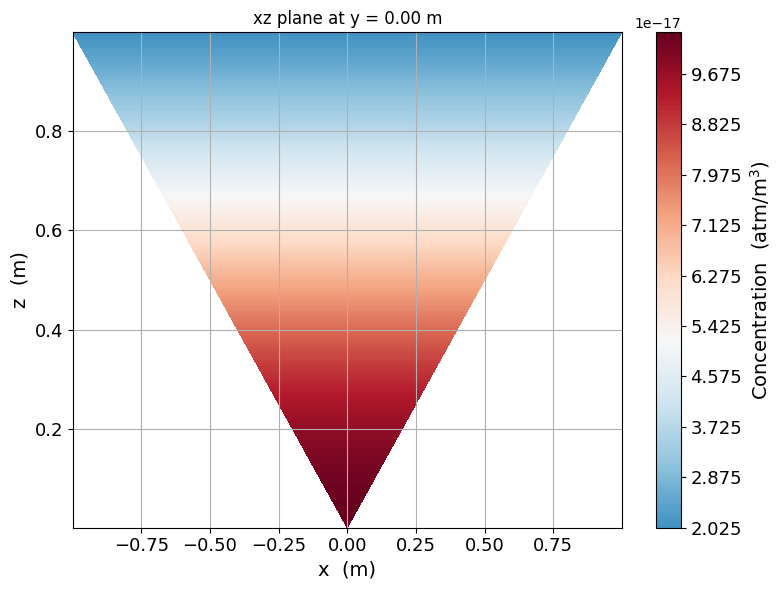

In [20]:
N_BOLT = 1.380649E-23  # [-]
ZZ = np.sort(list(set(coordinates_Pq[:, 1])))
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
        return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

field = ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE)

field = np.hstack((field, field))
coord_x = np.hstack((ZZ, - ZZ))
coord_z = np.hstack((ZZ,   ZZ))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

# max_tick = np.max(field)
# tick_step = 0.2e25
# print(max_tick)
# ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0)
cbar = plt.colorbar(contour)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 

#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('z  (m)',fontsize=14)
plt.title('xz plane at y = 0.00 m')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/reference case/FOM_xz.pdf', bbox_inches='tight')

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(field)  # Indice del valore massimo
z_max = coord_z[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

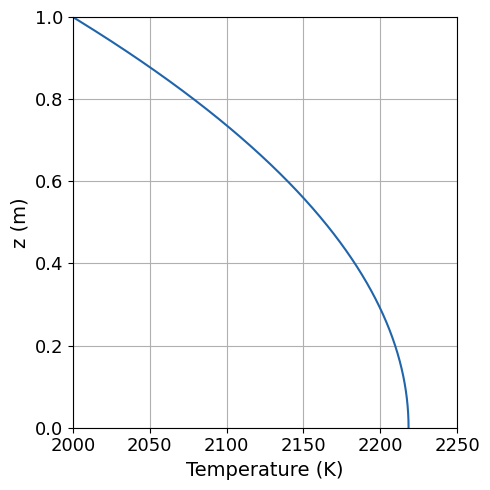

In [8]:
#OpenFOAM=pd.read_csv("data/OpenFOAM_Tprofile.csv")     

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

total_layers = list(set(coordinates_Px[:,1]))
all_layers = sorted(list(set(coordinates_Px[:, 1])))
effective_layers = np.linspace(all_layers[0], all_layers[-1], 5)  # Livelli da etichettare


fig, (ax1) = plt.subplots(1, figsize=(5,5))
#ax1.plot(OpenFOAM.iloc[:, 0], OpenFOAM.iloc[:, -1], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot( T_BC + GAMMA_T * (1 - np.linspace(0,1 ,1001)**2) / 2, np.linspace(0,1,1001),label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
#ax1.set_yticks(all_layers)  # Mostra tutti i tick
#ax1.set_yticklabels(
#    [f"{layer:.2f}" if layer in effective_layers else "" for layer in all_layers],
#    fontsize=13
#)  # Etichetta solo i livelli scelti, lasciando vuoti gli altri

ax1.set_ylim([0, 1])
ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('plot/reference case/Temperature profile.pdf', bbox_inches='tight') 

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
#print(np.max(error))

## ROM SOLUTION

In [9]:
# Apri il file in modalità lettura
with h5py.File('checkpoint/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]

print(basis.shape)
n_dofs = coordinates_Px.shape[0]
n_cols = basis.shape[1]
basis_extended = np.zeros((n_dofs, n_cols))
basis_extended[mask_in_C, :] = basis
print(basis_extended.shape)

(9900, 173)
(10201, 173)


In [10]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare
LU, PIV = sp.linalg.lu_factor(LHS_RB_static)

old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(1000):
    old_sol_RB = sp.linalg.lu_solve((LU, PIV), RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

reconstructed_field = np.dot(basis_extended, old_sol_RB[:,0])
print(reconstructed_field.shape)
np.savetxt('reference case/Reconstructed_field_reference.csv', reconstructed_field, delimiter=',', fmt='%d')

6.07824492920305e+22
1.1626510187397868e+23
1.6790523464444074e+23
2.164345952503937e+23
2.6231233594514924e+23
3.0586114501492084e+23
3.473240584359337e+23
3.868929044184863e+23
4.247243214017505e+23
4.609495547280394e+23
4.956808266667328e+23
5.2901567819067116e+23
5.6104004065423386e+23
5.918304753313685e+23
6.214558472262678e+23
6.499786023361633e+23
6.774557597688762e+23
7.039396943728672e+23
7.29478762636129e+23
7.541178094819613e+23
7.778985833243856e+23
8.008600796145497e+23
8.230388280521706e+23
8.444691349846212e+23
8.651832898385118e+23
8.852117424380868e+23
9.045832565676653e+23
9.233250439977854e+23
9.414628823224544e+23
9.590212192809629e+23
9.760232657130493e+23
9.924910788853308e+23
1.0084456376030311e+24
1.0239069102646051e+24
1.0388939168123549e+24
1.0534247853687014e+24
1.0675168042160664e+24
1.0811864696720382e+24
1.0944495303250234e+24
1.1073210280251442e+24
1.1198153359672746e+24
1.1319461941554673e+24
1.1437267424986159e+24
1.1551695517542658e+24
1.16628665251012

In [18]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
reconstructed_field = np.loadtxt('reference case/Reconstructed_field_reference.csv', delimiter=',')
FOM = sol_new_C[:, -1]
ROM = reconstructed_field 
print(rf'Dimensione di FOM = {FOM.shape}')
print(rf'Dimensione di ROM = {ROM.shape}')

FOM_minus_ROM = np.abs(FOM - ROM)
print(rf'Dimensione di FOM-ROM = {FOM_minus_ROM.shape}')
print(rf'Massimo differenza tra FOM-ROM = {np.max(FOM_minus_ROM)}')

FOM_minus_ROM = np.abs(FOM - ROM)/np.max(np.abs(FOM))
print(rf'Massima differenza relativo tra FOM-ROM = {np.max(FOM_minus_ROM)}')

Dimensione di FOM = (10201,)
Dimensione di ROM = (10201,)
Dimensione di FOM-ROM = (10201,)
Massimo differenza tra FOM-ROM = 1.783985936007168e+18
Massima differenza relativo tra FOM-ROM = 2.1821883170259885e-07


In [19]:
ABS_ERR = np.linalg.norm(FOM - ROM, axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(sol_new_C[:, -1], axis=0)
print(rf'Massimo errore relativo = {REL_ERR}')

Massimo errore relativo = 9.355039961737101e-08


2.1821883170259885e-07


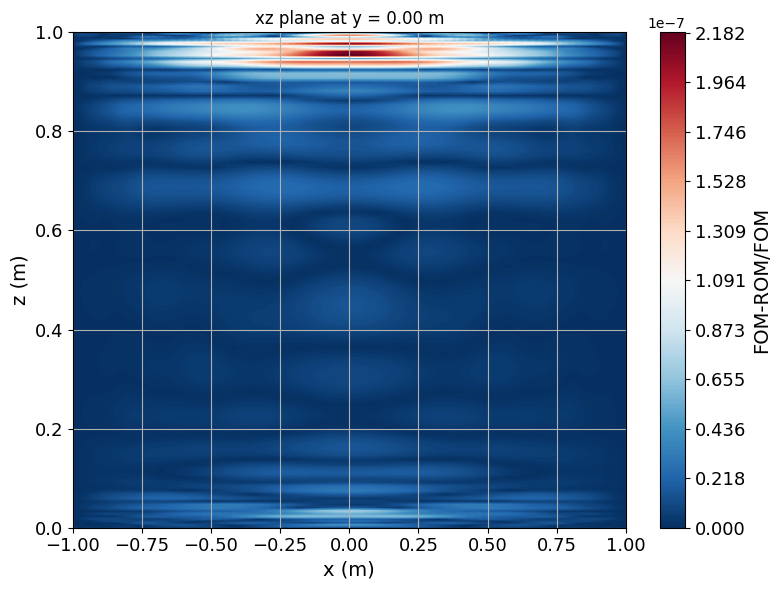

In [23]:
field = np.hstack((FOM_minus_ROM, FOM_minus_ROM))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = max_tick/10
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('FOM-ROM/FOM', fontsize=14)

plt.title(f'xz plane at y = {0.00:.2f} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/reference case/FOM-ROM.pdf', bbox_inches='tight') 